In [1]:
from utils.analytical.utils import *
from utils import plotcfg

# 3.1 Analytical Method
This chapter presents a detailed methodology for estimating external joint torques on a LARA8 equipped with Harmonic Drive Transmissions (HDTs) and dual encoders. Starting from measuring the transmission error using the dual encoders, the approach focuses on modelling and compensating for the transmission errors caused by known torques. The primary hypothesis is that any remaining deformation can be attributed to external forces by accounting for these known torques, thereby isolating the external joint torque.

To streamline the study's complexity and achieve precise torque estimations, the research was concentrated on a single robot joint. By focusing on a single joint, the number of variables that could influence the accuracy of the results is decreased and a more controlled and thorough analysis of the torque components is possible. Joint 3 was selected because of its greater range of motion and the large torque loads it usually encounters. This joint's configuration and operation make it particularly suitable for studying the effects of various torque components, both internal and external.


## 3.1.1 Experimental Setup and Data Collection

The robot was mounted horizontally, with its base attached to a vertical plane, positioning Joint 3 parallel to the gravity vector and allowing it to rotate in a Horizontal plane. This orientation effectively eliminated gravitational torque components on Joint 3, enabling a focused study on internal torques such as frictional and position-dependent torques. In this configuration, Joint 3 was rotated from its maximum limit in one direction to the maximum limit in the opposite direction, while all other joints remained fixed at 0°, thus covering the entire range of motion from -150° to 150°. Each recorded motion was done with randomly chosen joint velocity from a uniform distribution ranging from 0.01 rad/s to 1.15rad/s.

Data collection included recording joint velocity, joint angle, torque feedforward, load-side encoder counts, and motor-side encoder counts at every 2 ms interval. This high-resolution data sampling ensured that detailed and accurate information was captured.

In [2]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("analytical_dataset")
data = preprocess()

downloading data:   0%|          | 0/170923 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


preprocessing:   0%|          | 0/44 [00:00<?, ?it/s]

As discussed in Section 2, transmission error 𝜃_𝑒 can be represented by the following equation.
$$
\theta_e = \frac{\theta_m}{N }- \theta_l
$$
where $\theta_m$ corresponds to the input motor shaft position, $N$ is the gear ratio
and $\theta_l$ pertains to the output load shaft position. This equation captures the difference between the scaled motor position and the actual load position, effectively measuring the torsional deformation within the Harmonic Drive Transmission. 

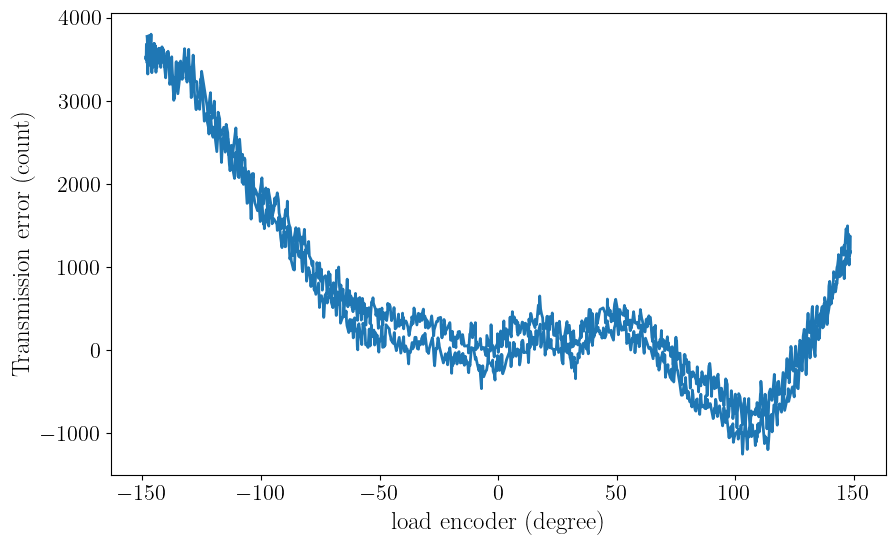

In [3]:
# A random sample from the collected data is selected, and its Transmission error is plotted
import random
random.seed(1997)

sample = random.choice(list(data.keys()))

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].encoder_motorinc_3/gear_ratio - data[sample].encoder_loadinc_3)
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder (degree)')
plt.show()

The encoder data received is notably affected by significant noise. To rectify this, a low-pass filter with a cut-off frequency set at 50 Hz is applied. This filter reduces the noise while preserving the integrity of the original data.

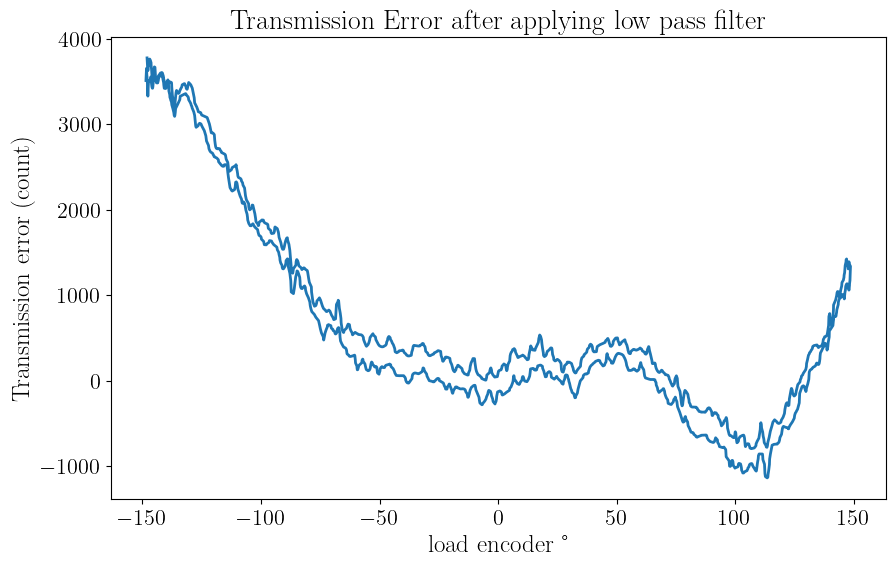

In [4]:
#apply low pass filter
for key in data:
    data[key]= filter(data[key],50)

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].filtered_motor_enc/gear_ratio - data[sample].filtered_load_enc,label ='encoder difference')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder °')
plt.title("Transmission Error after applying low pass filter")
plt.show()

## 3.1.2 Position Based Error

To model the characteristic position-based error also refered to as the "footprint", it is essential to understand the nature of transmission errors in harmonic drive systems. One source of these errors is torque caused by gear eccentricity and tooth profile errors specific to each Harmonic Drive Transmission.
The transmission error exhibits periodic behaviour in relation to the joint position. Building on earlier research<cite id="bdeq8"><a href="#zotero%7C17740253%2FERHLXZ6B">[Kulkarni,2024]</a></cite>, a Fourier series model captures this periodic nature well. This model decomposes the error into sine and cosine terms, each representing different frequency components associated with the gear's rotational position. The  formula for the Fourier series used to model the transmission error is as follows:
$$
θ_e(θ_m,θ_l)=A_0+\Sigma^{10}_{n=1}[A_ncos(\omega_{m(n)}θ_m)+B_nsin(\omega_{m(n)}θ_m)] + \Sigma^{30}_{n=1}[C_ncos(nθ_l)+D_nsin(nθ_l)]
$$

Here, $A_0$ represents the static offset, which can be influenced by factors such as the direction of motion and any consistent bias in the system. The coefficients $A_n$,$B_nC_n$ and $D_n$ correspond to the amplitude of the cosine and sine components at each harmonic frequency $\omega_m$. These coefficients are determined based on empirical data, capturing the specific characteristics of the transmission error for a given harmonic drive.

The slowest speed among the collected data sets was selected for further analysis to minimize the effects of velocity dependant dynamic forces such as Coriolis and centrifugal terms. This selection ensured that the torques associated with accelerating and decelerating the joint at this low velocity were negligible and of minimal duration. This focus allowed for isolating primarily frictional and position-dependent torques, providing the data for accurately modeling the characteristic position-based error in the harmonic drive system.

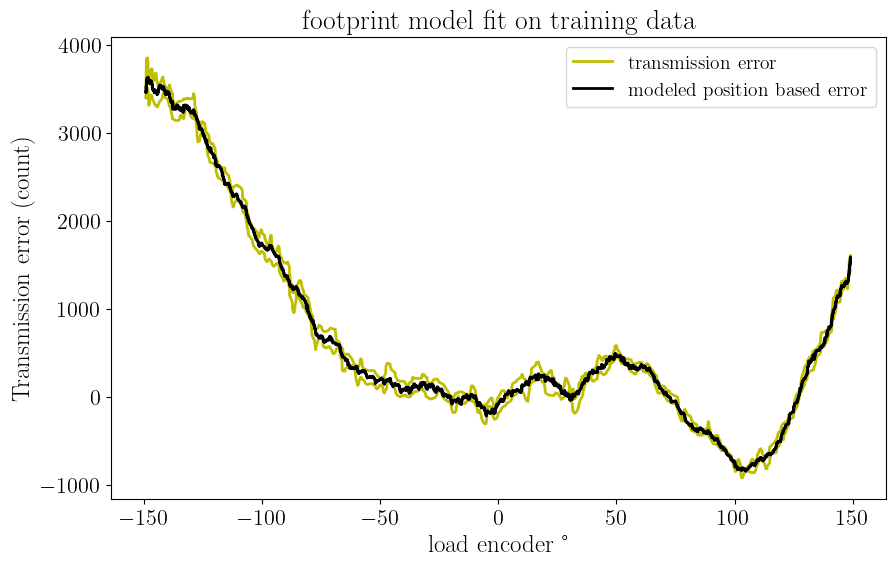

In [5]:
#learn characteristic footprint error from the slowest data 
footprint_coeff = model_footprint(data["0.01"])
np.save("utils/analytical/footprint_coeff.npy",footprint_coeff)

for key in data:
    data[key]['modeled_footprint'] = data[key].apply(lambda row: footprint_error(footprint_coeff,row["filtered_motor_enc"], row["filtered_load_enc"]), axis=1)


plt.plot(data["0.01"].encoder_loadinc_3*count_to_deg, (data["0.01"].filtered_motor_enc/gear_ratio - data["0.01"].filtered_load_enc) ,'y',label = 'transmission error')
plt.plot(data["0.01"].encoder_loadinc_3*count_to_deg,data["0.01"].modeled_footprint/count_to_deg,'black',label = 'modeled position based error')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on training data")
plt.show()

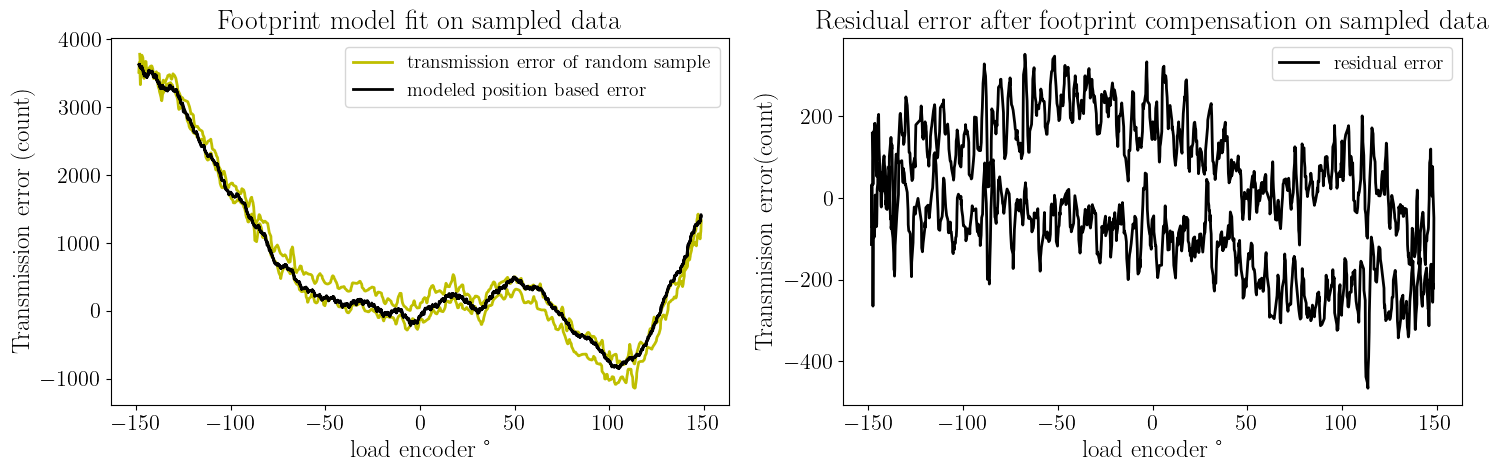

In [6]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First plot: Footprint model fit on sampled data
ax1.plot(data[sample].encoder_loadinc_3 * count_to_deg,
         (data[sample].filtered_motor_enc / gear_ratio - data[sample].filtered_load_enc), 'y', label='transmission error of random sample')
ax1.plot(data[sample].encoder_loadinc_3 * count_to_deg,
         data[sample].modeled_footprint / count_to_deg, 'black', label='modeled position based error')
ax1.set_ylabel('Transmission error (count)')
ax1.set_xlabel('load encoder °')
ax1.legend()
ax1.set_title("Footprint model fit on sampled data")

# Calculate residuals by compensating for footprint
for key in data:
    data[key]['residual_error'] = data[key].filtered_motor_enc / gear_ratio - data[key].filtered_load_enc - data[key].modeled_footprint / count_to_deg

# Second plot: Residual error after footprint compensation on randomly sampled dataset
ax2.plot(data[sample].encoder_loadinc_3 * count_to_deg,data[sample].residual_error, 'black', label='residual error')
ax2.set_ylabel('Transmisison error(count)')
ax2.set_xlabel('load encoder °')
ax2.legend()
ax2.set_title("Residual error after footprint compensation on sampled data")

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()

## 3.1.3 Dynamic Torque Compensation
The dynamic torque (refer to Equation in Chapter 2) is a component of the output torque generated by the transmission. In this configuration, gravitational torques are negligible. The trajectory maintains a constant velocity, resulting in acceleration only at the beginning and end of the motion. Therefore, apart from acceleration at joint limits, the dynamic torque primarily consists of frictional forces, which accounts for the friction occurring within the motor and other joint parts, including the Harmonic Drive Transmission (HDT). As a portion of the friction torque is inherently dissipated within the motor, only the fraction attributable to the transmission error necessitates compensation. Consequently, the entire friction component is subtracted from the torque, ensuring that the transmission error due to inherent dynamic effects associated with the robot's motion are accurately compensated. The frictional torque specific to the HDT will be modeled and compensated in a subsequent phase of this analysis.

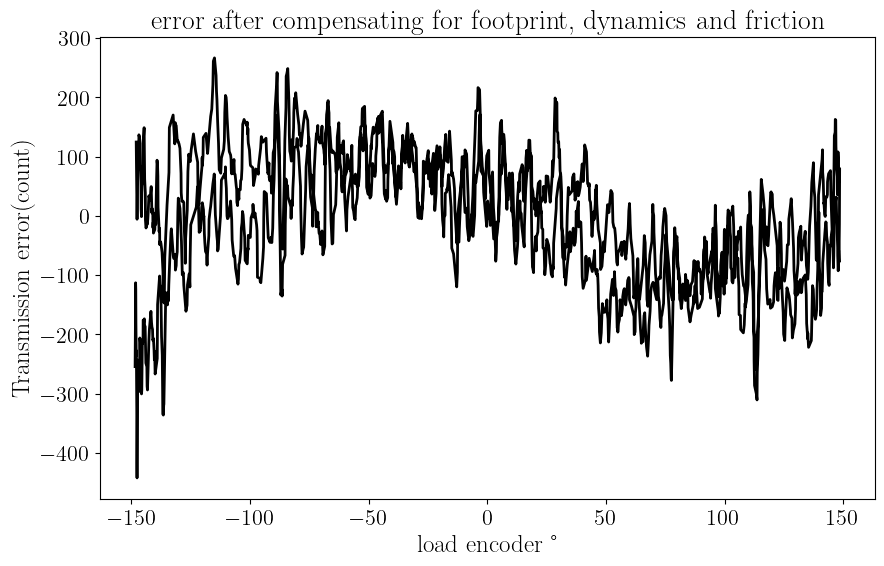

In [7]:
#compensat for dynamics(remove friction component in dynamic)
for key in data:
    data[key]['inverse_dynamics'] =  data[key].apply(lambda row:row["target_joint_torque_3"] - controller_friction_estimate(row["joint_velocity_3"]), axis=1)
    data[key]["dynamic_compensation"] = data[key].apply(lambda row: torque_to_encoder_error(row["inverse_dynamics"]), axis=1)
    data[key]["residual_error2"] = data[key].residual_error - data[key].dynamic_compensation
plt.plot(data[sample].encoder_loadinc_3*count_to_deg, data[sample].residual_error2,'black')
plt.ylabel('Transmission error(count)')
plt.xlabel('load encoder °')
plt.title("error after compensating for footprint, dynamics and friction ")
plt.show()

## 3.1.4 Friction compensation
The only remaining torque to be modelled is the frictional torque in the HDT, which is velocity-dependent. Using the friction model below, the parameters were identified through non-linear least squares fitting, aligning the model with the observed frictional behaviour:
$$
f(v) = a_1 (\tanh(b_1 v) - \tanh(b_2 v)) + a_2 \tanh(b_3 v) + a_3 v
$$
where $v$ represents the joint velocity, $a_1,a_2,a_3 ,b1,b2,b3$ are parameters that are found in the fitting. Since encoder error is synonimous to torque, the model was used in this study to map velocity to transmission error instead of the original model's intended mapping of torque to velocity<cite id="mf1cg"><a href="#zotero%7C17740253%2FYSG8J3F3">[Chen,2018]</a></cite>. This adaptation effectively represents the frictional torque component through transmission error, encapsulating the characteristics of the friction present in the system.

In [8]:
def friction_model(v,a1,a2,a3,b1,b2,b3):
    return a1*(np.tanh(b1*v)-np.tanh(b2*v))+a2*np.tanh(b3*v)+a3*v

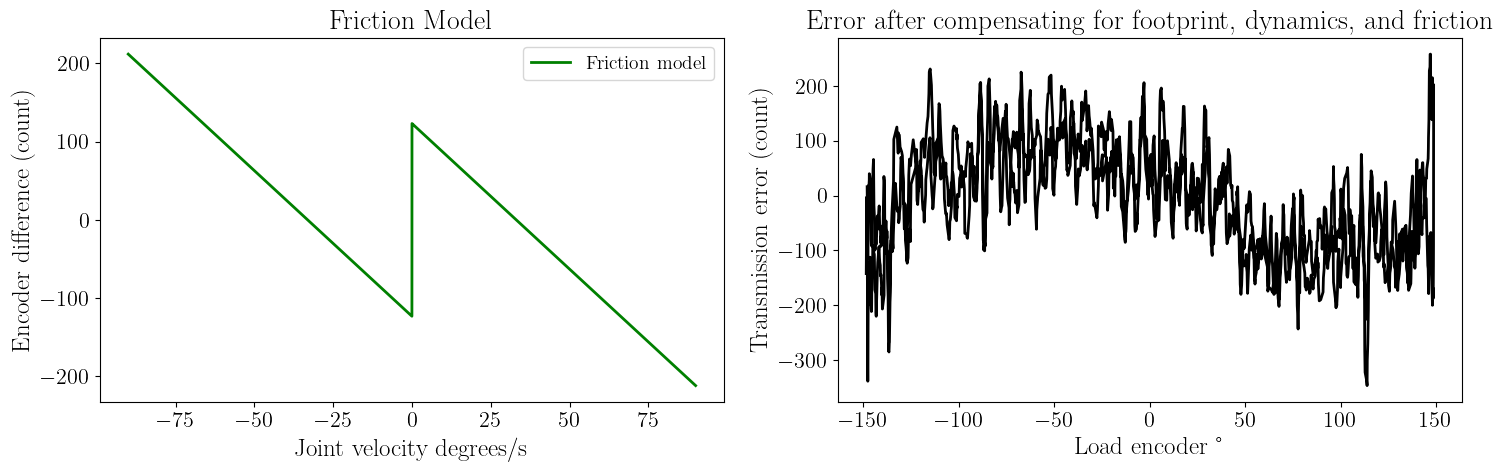

In [9]:
# Calculate parameters for the friction model
parameters, _ = curve_fit(friction_model, data[sample].joint_velocity_3 * radian_to_deg, data[sample].residual_error2)
np.save("utils/analytical/friction_coeff.npy", parameters)

y = np.arange(-90, 90, 0.01)
x = friction_model(y, *parameters)

# Compensate for friction in the data
for key in data:
    data[key]['modeled_friction'] = data[key].apply(
        lambda row: friction_model(row["filtered_joint_velocity"] * radian_to_deg, *parameters),
        axis=1
    )
    data[key]["residual_error3"] = data[key].residual_error2 - data[key].modeled_friction

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Friction model
axs[0].plot(y, x, 'g', label='Friction model')
axs[0].set_xlabel("Joint velocity degrees/s")
axs[0].set_ylabel("Encoder difference (count)")
axs[0].set_title("Friction Model")
axs[0].legend()

# Second subplot: Error after compensation
axs[1].plot(data[sample].encoder_loadinc_3 * count_to_deg, data[sample].residual_error3, 'black')
axs[1].set_xlabel('Load encoder °')
axs[1].set_ylabel('Transmission error (count)')
axs[1].set_title("Error after compensating for footprint, dynamics, and friction")

plt.tight_layout()
plt.show()


## 3.1.5 External Torque 
The residual transmission error can now be converted to torque using [eqn ref].

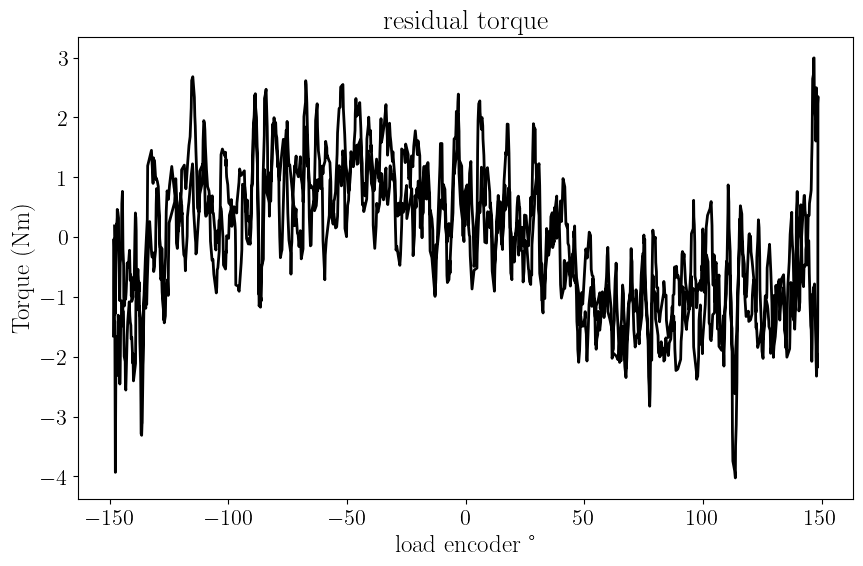

In [10]:
#convert residual transmission error to torque
for key in data:
    data[key]['torque_estimate'] = data[key].apply(lambda row: encoder_error_to_torque(row["residual_error3"]),axis=1)
plt.plot(data[sample].encoder_loadinc_3*count_to_deg, data[sample].torque_estimate,'black')
plt.ylabel('Torque (Nm)')
plt.xlabel('load encoder °')
plt.title("residual torque ")
plt.show()

The remaining residual torque, after compensating for all known components, indicates the presence of unmodeled torques or inaccuracies within the existing torque models. According to our hypothesis, this residual torque corresponds to the unaccounted external forces acting on the system. Since it was ensured that the external forces were zero during data collection, the existence of these residuals suggests that the current models do not fully capture all dynamic effects. These findings motivate the need for a more robust approach, potentially incorporating multiple sources of torque information, such as motor currents. This observation leads to the next chapter, where machine learning techniques are employed to learn and model the external torques.

## References
